In [1]:
# Image Colorization #

In [2]:
# Importing Libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Function to Colorize Images

def colorize_image(image_file):
    # Assigning Model File Paths
    prototxt = './src/colorization_deploy_v2.prototxt'
    caffemodel = './src/colorization_release_v2.caffemodel'
    hull = './src/pts_in_hull.npy'

    # Loading Model & Proto Files and Hull Points from Disk
    net = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
    pts = np.load(hull)

    # Adding the Cluster Centers as 1x1 Convolutions to the Model
    layer_class8 = net.getLayerId("class8_ab")
    layer_conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(layer_class8).blobs = [pts.astype("float32")]
    net.getLayer(layer_conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    # Loading the Input Image
    image = cv2.imread(image_file)
    
    # Converting Image from BGR to RGB
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalizing the Image by Changing Pixel Values to the Range of [0, 1]
    normalized = image.astype("float32") / 255.0
    # Converting the Normalized Image from BGR to LAB Color Space
    #lab_image = cv2.cvtColor(normalized, cv2.COLOR_RGB2LAB)
    lab_image = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)
    
    # Resizing the Lab Image to 224 x 224
    resized_lab_image = cv2.resize(lab_image, (224, 224))
    # Splitting Channels and Extracting the 'L' Channel
    L = cv2.split(resized_lab_image)[0]
    # Mean Centering
    L -= 50

    # Sending 'L' Channel to the Network to Predict 'a' and 'b' Channel Values
    net.setInput(cv2.dnn.blobFromImage(L))
    # Finding the Values of 'a' and 'b' Channels
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    # Resizing the Predicted 'ab' Volume to the Input Image Size
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

    # Grabbing the 'L' Channel from the Original Input Image
    L = cv2.split(lab_image)[0]
    # Concatenating the Original 'L' Channel with the Predicted 'ab' Channels
    lab_colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # Converting the Output Image from the LAB Color Space to RGB
    #rgb_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2RGB)
    bgr_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2BGR)
    # Clipping Any Values that Fall Outside the Range of [0, 1]
    bgr_colorized = np.clip(bgr_colorized, 0, 1)

    # Converting the Colorized Image from "Float" in [0, 1] to Unsigned 8-bit "Int" in: [0, 255]
    bgr_colorized = (255 * bgr_colorized).astype("uint8")

    # Combining the Original and the Colorized Image with A Borderline
    h = image.shape[0]
    border = np.zeros((h, int(h / 100), 3), dtype=np.uint8)
    concatenated = cv2.hconcat([image, border, bgr_colorized])

    # Returning the Colorized, Concatenated and Original Image
    return bgr_colorized, concatenated, image

In [4]:
# Function to Plot and Save the Colorized Images
def plot_colorized(image_file, concat=False):
    if concat:
        colorized = colorize_image(image_file)[1]
    else:
        colorized = colorize_image(image_file)[0]
        
    h, w = colorized.shape[0], colorized.shape[1]
    plt.figure(figsize=(int(6 * w / h), 6)); plt.axis('off')
    plt.imshow(cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB));
    cv2.imwrite(f"{image_file.rsplit('.', 1)[0]}_colorized.jpg", colorized);

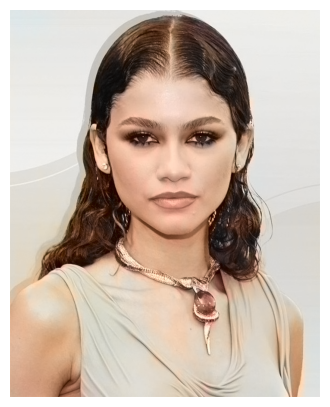

In [5]:
# Testing the Functions

file = "./images/zendaya.jpg"
plot_colorized(file)

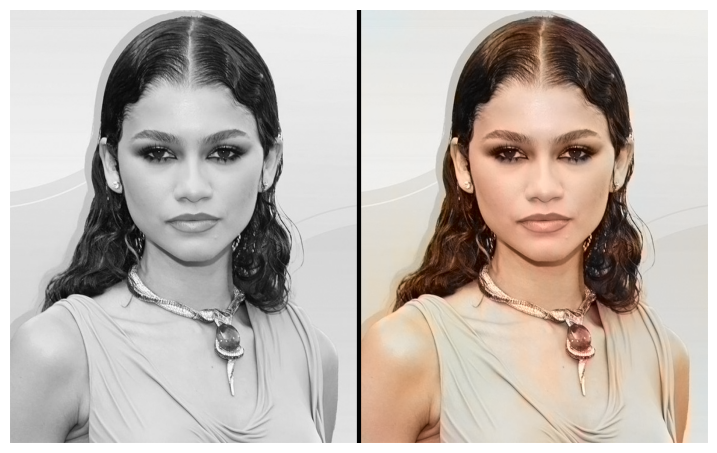

In [6]:
file = "./images/zendaya.jpg"
plot_colorized(file, concat=True)

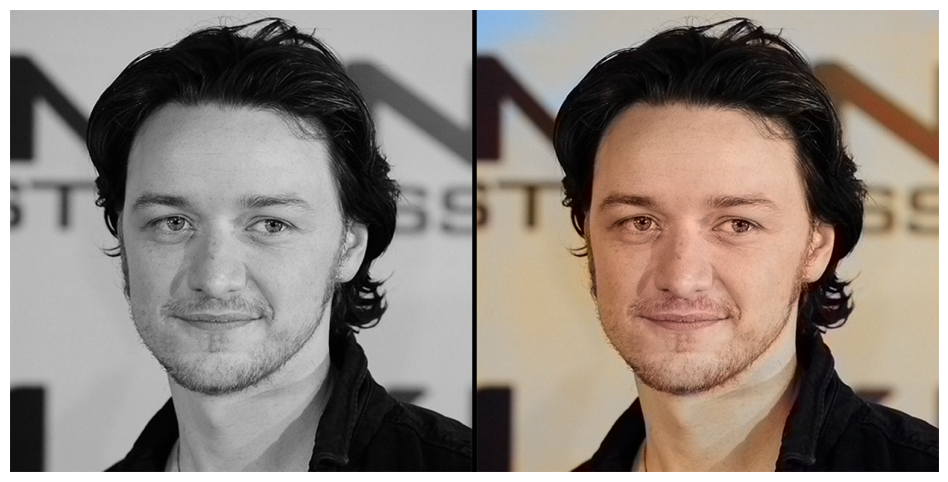

In [7]:
file = "./images/mcavoy.jpg"
plot_colorized(file, concat=True)

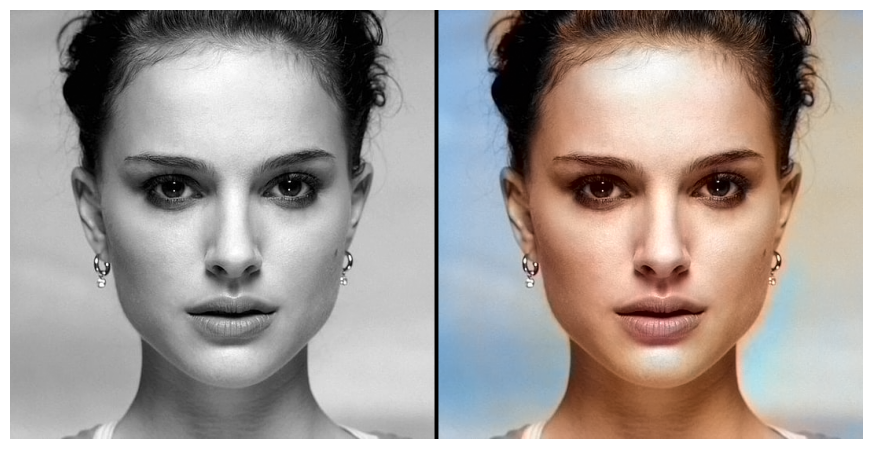

In [8]:
file = "./images/portman.png"
plot_colorized(file, concat=True)

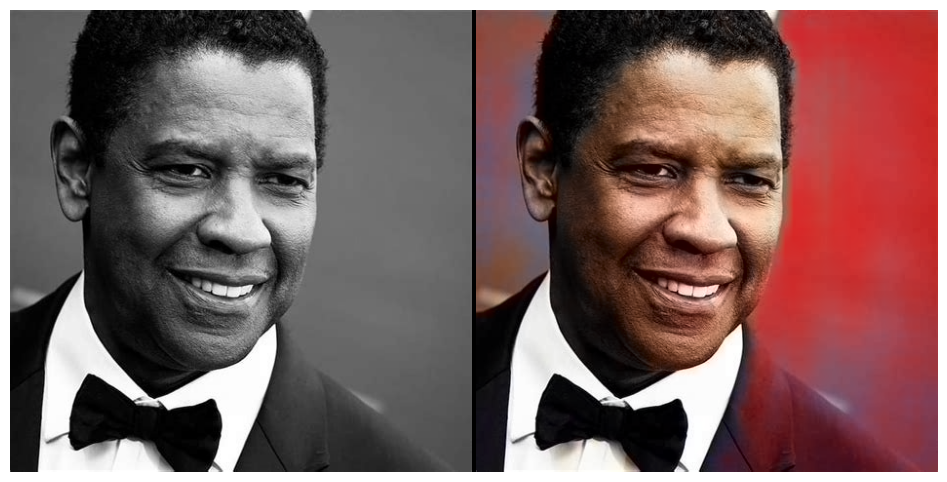

In [9]:
file = "./images/denzel.jpg"
plot_colorized(file, concat=True)

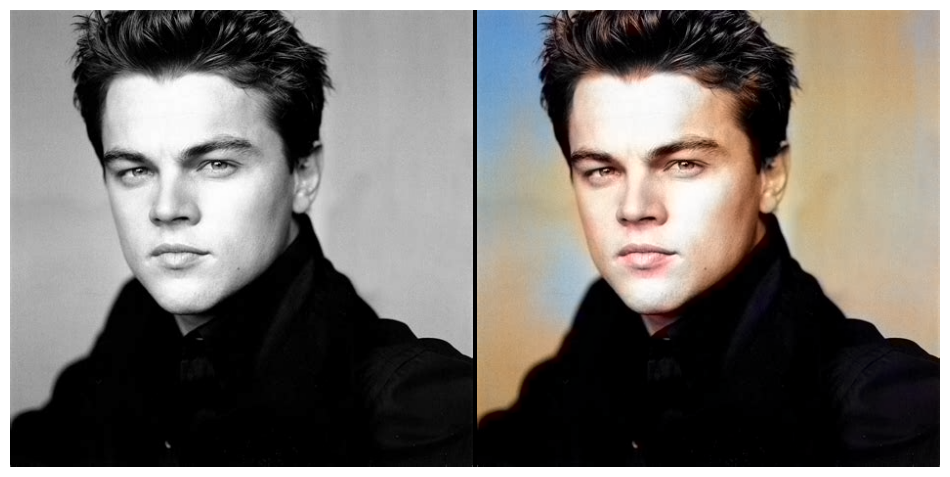

In [10]:
file = "./images/leonardo.jpg"
plot_colorized(file, concat=True)